In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
path = '/kaggle/input/titanic/'
test = pd.read_csv(path+"test.csv",index_col='PassengerId')
train = pd.read_csv(path+"train.csv",index_col='PassengerId')
train.head()





# train.dropna(axis=0, subset=['Survived'], inplace=True)
# y = train.Survived              
# train.drop(['Survived'], axis=1, inplace=True)
# X = train.select_dtypes(exclude=['object'])
# X_test = test.select_dtypes(exclude=['object'])
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,shuffle=True)
# X_train.head()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

X=train.copy()
y = X.pop('Survived')           

features_num = [
    "Pclass","Age","SibSp","Parch","Fare"
]
features_cat = [
    "Name","Sex","Ticket","Cabin","Embarked"
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore',sparse=False),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test  = preprocessor.transform(test)

input_shape = [X_train.shape[1]]

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(80, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(55, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(50, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

opt = keras.optimizers.Adam(learning_rate=0.001,epsilon=10e-7)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=120,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
6/6 [==============================] - 0s 50ms/step - loss: 0.9166 - binary_accuracy: 0.5225 - val_loss: 0.6771 - val_binary_accuracy: 0.6089
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.8416 - binary_accuracy: 0.5183 - val_loss: 0.6710 - val_binary_accuracy: 0.6313
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.7901 - binary_accuracy: 0.5435 - val_loss: 0.6656 - val_binary_accuracy: 0.6145
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.7014 - binary_accuracy: 0.6081 - val_loss: 0.6601 - val_binary_accuracy: 0.6145
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6719 - binary_accuracy: 0.6166 - val_loss: 0.6552 - val_binary_accuracy: 0.6145
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6690 - binary_accuracy: 0.6250 - val_loss: 0.6503 - val_binary_accuracy: 0.6145
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5943 

Best Validation Loss: 0.5230
Best Validation Accuracy: 0.7933


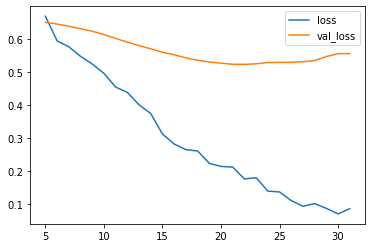

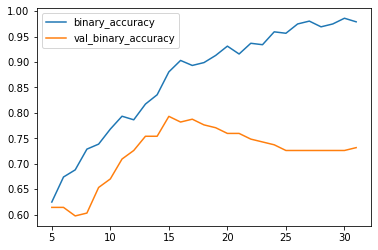

In [4]:


history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))



In [5]:
pred= model.predict(
    X_test, batch_size=512
)
pred=np.squeeze(pred)
print(pred)
pred = map(int,(pred > 0.5))
output = pd.DataFrame({'PassengerId': test.index,
                       'Survived': pred})
print(output)
output.to_csv('submission.csv', index=False)


[0.30228773 0.57783884 0.33664107 0.28199235 0.69119084 0.28379542
 0.7502112  0.34651786 0.7596952  0.263291   0.28327143 0.41231623
 0.80429286 0.32465947 0.8025588  0.7457099  0.36371505 0.33935535
 0.59181714 0.75880444 0.5226181  0.2858645  0.7262375  0.5704426
 0.9407335  0.22329095 0.87805784 0.33946687 0.49309474 0.3422853
 0.31934685 0.3078039  0.6651459  0.716256   0.60956985 0.33887
 0.60403955 0.6205517  0.28287488 0.3694725  0.460138   0.46884444
 0.27942246 0.67942834 0.7965684  0.28136307 0.59745777 0.3328849
 0.89828646 0.70718735 0.49933666 0.4035553  0.6739916  0.88910735
 0.4018696  0.2325468  0.2805286  0.3682009  0.27622366 0.92478156
 0.2820394  0.33354875 0.28181267 0.7056031  0.7997504  0.67890143
 0.7058285  0.43469524 0.5900968  0.9136855  0.7060683  0.28150576
 0.6275334  0.58734244 0.9219419  0.781381   0.28340128 0.73775625
 0.3335969  0.7060683  0.33858377 0.5983367  0.4113459  0.28327143
 0.38458204 0.33107352 0.70742327 0.6171383  0.70701015 0.34508643
 